### Import libraries

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import json
from datetime import datetime as dt

plt.rcParams['figure.figsize'] = (20, 12)
plt.style.use('fivethirtyeight')

### Get data from Binance API

In [8]:
def get_klines(symbol, interval, limit=500):
    url = 'https://fapi.binance.com/fapi/v1/klines'
    
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit
    }
    
    data = pd.DataFrame(json.loads(requests.get(url, params=params).text))
    data = data.iloc[:,0:6]
    data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    data['Open Time'] = [dt.fromtimestamp(x / 1000) for x in data['Open Time']]
    data['Open'] = data['Open'].astype(float)
    data['High'] = data['High'].astype(float)
    data['Low'] = data['Low'].astype(float)
    data['Close'] = data['Close'].astype(float)
    
    return data
    

In [9]:
data = get_klines('BTCUSDT', '1h')
data

,Open Time,Open,High,Low,Close,Volume
0,2024-01-02 04:00:00,45420.0,45565.0,45167.3,45435.0,18878.543
1,2024-01-02 05:00:00,45434.9,45484.4,45193.1,45211.7,11326.594
2,2024-01-02 06:00:00,45211.5,45366.0,45153.0,45218.2,7931.571
3,2024-01-02 07:00:00,45218.2,45346.2,45163.9,45202.9,5712.130
4,2024-01-02 08:00:00,45202.9,45832.8,45202.5,45495.5,21647.544
...,...,...,...,...,...,...
495,2024-01-22 19:00:00,40714.9,40803.2,39965.0,40320.7,34172.347
496,2024-01-22 20:00:00,40320.7,40576.0,39402.0,39812.5,71402.146
497,2024-01-22 21:00:00,39812.6,40360.0,39746.9,40181.8,30013.751
498,2024-01-22 22:00:00,40181.7,40203.1,39839.6,39854.4,15246.066


### Get RSI indicator

In [37]:
def get_rsi(data, lookback):
    ret = data['Close'].diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
            
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com=lookback, adjust=False).mean()
    down_ewm = down_series.ewm(com=lookback, adjust=False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns={0: 'rsi'}).set_index(data['Close'].index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

In [39]:
data['rsi_14'] = get_rsi(data, 14)
data = data.dropna()
data

,Open Time,Open,High,Low,Close,Volume,rsi_14
4,2024-01-02 08:00:00,45202.9,45832.8,45202.5,45495.5,21647.544,60.365556
5,2024-01-02 09:00:00,45495.6,45905.9,45365.0,45816.8,27098.848,76.640697
6,2024-01-02 10:00:00,45816.8,45950.0,45667.7,45730.5,14217.371,68.541051
7,2024-01-02 11:00:00,45730.0,45772.8,45478.0,45655.7,13818.668,62.415398
8,2024-01-02 12:00:00,45655.7,45767.6,45258.0,45486.8,17990.732,51.319230
...,...,...,...,...,...,...,...
495,2024-01-22 19:00:00,40714.9,40803.2,39965.0,40320.7,34172.347,32.269071
496,2024-01-22 20:00:00,40320.7,40576.0,39402.0,39812.5,71402.146,25.960807
497,2024-01-22 21:00:00,39812.6,40360.0,39746.9,40181.8,30013.751,35.741348
498,2024-01-22 22:00:00,40181.7,40203.1,39839.6,39854.4,15246.066,31.756625


### Plot the data and RSI indicator

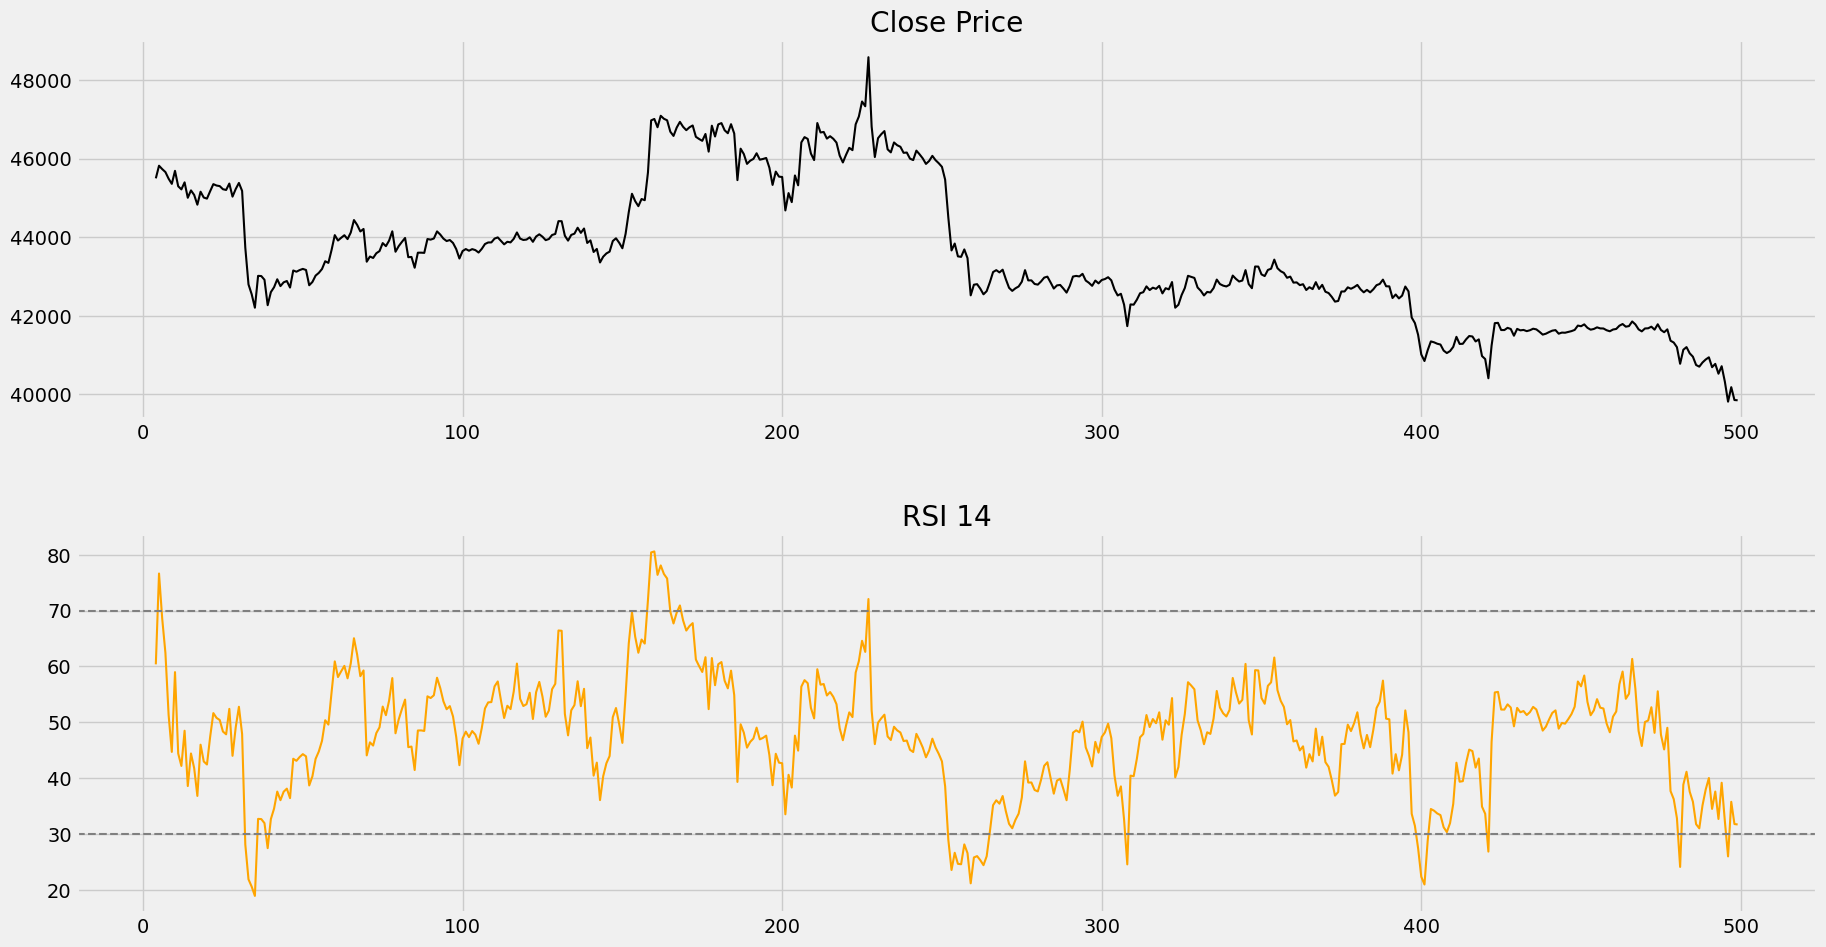

In [43]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan=4, colspan=1)

ax1.plot(data['Close'], linewidth=1.5, color='black')
ax1.set_title('Close Price')

ax2.plot(data['rsi_14'], color='orange', linewidth=1.5)
ax2.axhline(30, linestyle='--', linewidth=1.5, color='grey')
ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.set_title('RSI 14')
plt.show()

### Implement Strategy

In [55]:
def implement_rsi_strategy(data, price, rsi):
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0
    
    for i in range(len(data)):
        
        if data[rsi].iloc[i-1] > 30 and data[rsi].iloc[i] < 30:
            if signal != 1:
                buy_price.append(data[price].iloc[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif data[rsi].iloc[i-1] < 70 and data[rsi].iloc[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[price].iloc[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal

In [56]:
buy_price, sell_price, rsi_signal = implement_rsi_strategy(data, 'Close', 'rsi_14')
rsi_signal

[0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0

### Plot strategy signals

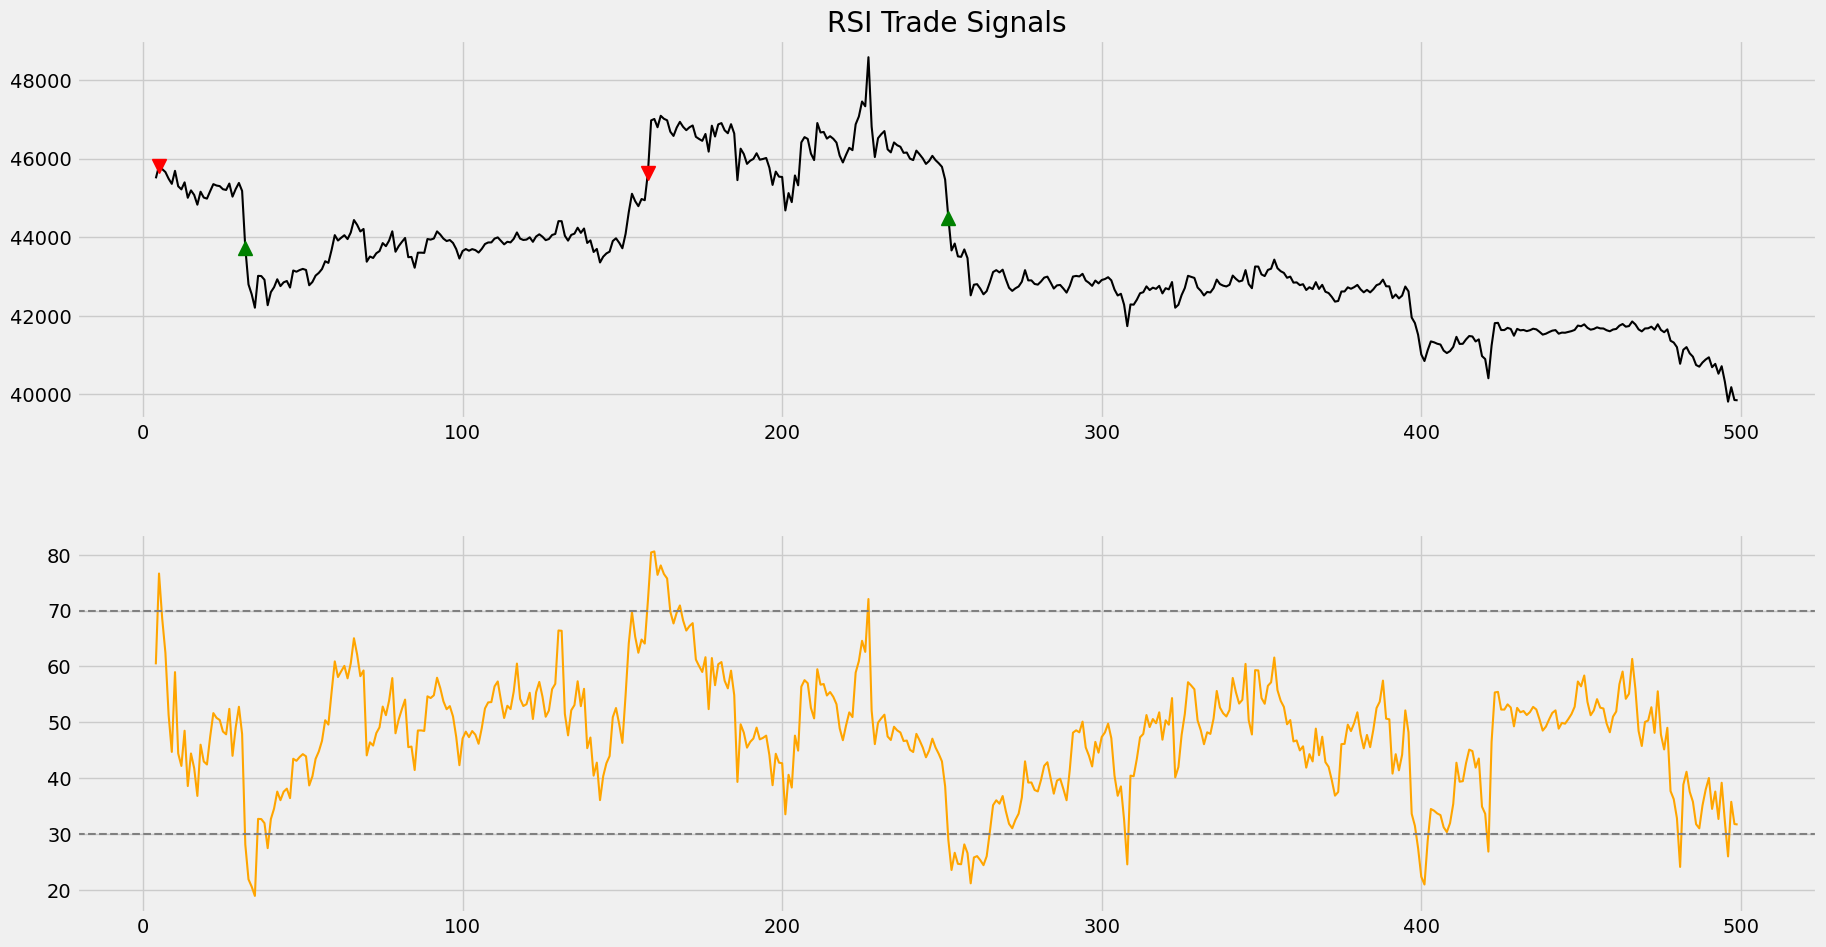

In [58]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan=4, colspan=1)

ax1.plot(data['Close'], linewidth=1.5, color='black', label='Price')
ax1.plot(data.index, buy_price, marker='^', markersize=10, color='green', label='BUY Signal')
ax1.plot(data.index, sell_price, marker='v', markersize=10, color='red', label='SELL Signal')
ax1.set_title('RSI Trade Signals')

ax2.plot(data['rsi_14'], linewidth=1.5, color='orange')
ax2.axhline(30, linestyle='--', linewidth=1.5, color='grey')
ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')

plt.show()
